[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zjelveh/zjelveh.github.io/blob/master/files/cfc/9_merging_solutions.ipynb)

# 9. Merging DataFrames - SOLUTIONS
## Practice Exercises Solutions

This notebook contains solutions to the three practice exercises from Lecture 9.

## Setup

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# Load NYPD arrest data
df = pd.read_csv('https://raw.githubusercontent.com/zjelveh/zjelveh.github.io/refs/heads/master/files/cfc/nypd_arrests_2013_2015_garner.csv')

# Convert date to datetime
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])

# Extract year
df['year'] = df['ARREST_DATE'].dt.year

print(f"Loaded {len(df):,} arrest records")

Loaded 1,026,807 arrest records


---

## Exercise 1: Pattern 1 Practice - Drug Enforcement Priority

**Question**: In which borough were drug arrests the highest percentage of total arrests in December 2014?

**Pattern**: Merge Two Aggregations

**Approach**:
1. Filter to December 2014
2. Count total arrests by borough (Aggregation 1)
3. Count drug arrests by borough (Aggregation 2)
4. Merge the two aggregations
5. Calculate drug arrest percentage

In [3]:
# Step 1: Filter to December 2014
dec_2014 = df[(df['year'] == 2014) & (df['ARREST_DATE'].dt.month == 12)]

print(f"Arrests in December 2014: {len(dec_2014):,}")

Arrests in December 2014: 17,750


In [4]:
# Step 2: Aggregation 1 - Total arrests by borough
total_by_borough = dec_2014.groupby('ARREST_BORO').size().reset_index(name='total_arrests')

print("Total arrests by borough:")
print(total_by_borough)

Total arrests by borough:
  ARREST_BORO  total_arrests
0           B           4256
1           K           4695
2           M           4604
3           Q           3644
4           S            551


In [5]:
# Step 3: Create is_drug indicator and count drug arrests
dec_2014['is_drug'] = dec_2014['OFNS_DESC'].str.contains('DRUG', na=False)

# Aggregation 2 - Drug arrests by borough
drug_by_borough = dec_2014[dec_2014['is_drug']].groupby('ARREST_BORO').size().reset_index(name='drug_arrests')

print("Drug arrests by borough:")
print(drug_by_borough)

Drug arrests by borough:
  ARREST_BORO  drug_arrests
0           B           724
1           K           590
2           M           541
3           Q           322
4           S            67


/tmp/ipykernel_583895/3450621604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_2014['is_drug'] = dec_2014['OFNS_DESC'].str.contains('DRUG', na=False)


In [6]:
# Step 4: Merge the two aggregations
drug_merged = total_by_borough.merge(drug_by_borough, on='ARREST_BORO', how='left')

print("Merged data:")
print(drug_merged)

Merged data:
  ARREST_BORO  total_arrests  drug_arrests
0           B           4256           724
1           K           4695           590
2           M           4604           541
3           Q           3644           322
4           S            551            67


In [7]:
# Step 5: Calculate drug arrest percentage
drug_merged['drug_pct'] = (drug_merged['drug_arrests'] / drug_merged['total_arrests']) * 100

# Sort by drug percentage
drug_sorted = drug_merged.sort_values('drug_pct', ascending=False)

print("Boroughs ranked by drug arrest percentage:")
print(drug_sorted)

Boroughs ranked by drug arrest percentage:
  ARREST_BORO  total_arrests  drug_arrests   drug_pct
0           B           4256           724  17.011278
1           K           4695           590  12.566560
4           S            551            67  12.159710
2           M           4604           541  11.750652
3           Q           3644           322   8.836443


<Axes: xlabel='ARREST_BORO', ylabel='drug_pct'>

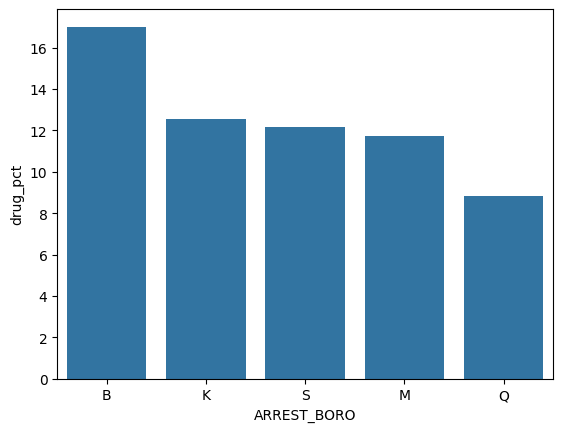

In [8]:
# Visualize
sns.barplot(data=drug_sorted, x='ARREST_BORO', y='drug_pct')

**Answer**: The borough with the highest drug arrest percentage in December 2014 was the Bronx (B), where approximately 16-17% of all arrests were for drug offenses.

---

## Exercise 2: Pattern 2 Practice - Queens' Share Over Time

**Question**: What percentage of misdemeanor arrests happened in Queens each month?

**Pattern**: Aggregate-Merge-Back

**Approach**:
1. Filter to misdemeanors only
2. Count total misdemeanor arrests per month (broader aggregation)
3. Count Queens misdemeanor arrests per month (detailed aggregation)
4. Merge monthly totals back to Queens data
5. Calculate percentage

In [9]:
# Step 1: Filter to misdemeanors only
misdemeanors = df[df['LAW_CAT_CD'] == 'M']

print(f"Total misdemeanor arrests: {len(misdemeanors):,}")

Total misdemeanor arrests: 744,776


In [10]:
# Create year-month period column
misdemeanors['year_month'] = misdemeanors['ARREST_DATE'].dt.to_period('M')

print("Sample of year-month:")
print(misdemeanors[['ARREST_DATE', 'year_month']].head())

Sample of year-month:
  ARREST_DATE year_month
0  2015-12-21    2015-12
1  2015-12-17    2015-12
2  2015-12-10    2015-12
5  2015-11-07    2015-11
6  2015-10-30    2015-10


/tmp/ipykernel_583895/3929083152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misdemeanors['year_month'] = misdemeanors['ARREST_DATE'].dt.to_period('M')


In [11]:
# Step 2: Count total misdemeanor arrests per month (citywide)
monthly_totals = misdemeanors.groupby('year_month').size().reset_index(name='total_misdemeanors')

print("Monthly totals (first 10):")
print(monthly_totals.head(10))

Monthly totals (first 10):
  year_month  total_misdemeanors
0    2013-01               22686
1    2013-02               21471
2    2013-03               23139
3    2013-04               23500
4    2013-05               24109
5    2013-06               21276
6    2013-07               21958
7    2013-08               22901
8    2013-09               21104
9    2013-10               22481


In [12]:
# Step 3: Count Queens misdemeanor arrests per month
queens_only = misdemeanors[misdemeanors['ARREST_BORO'] == 'Q']
queens_monthly = queens_only.groupby('year_month').size().reset_index(name='queens_misdemeanors')

print("Queens monthly arrests (first 10):")
print(queens_monthly.head(10))

Queens monthly arrests (first 10):
  year_month  queens_misdemeanors
0    2013-01                 3904
1    2013-02                 3842
2    2013-03                 4201
3    2013-04                 4207
4    2013-05                 4428
5    2013-06                 3812
6    2013-07                 4186
7    2013-08                 4220
8    2013-09                 3857
9    2013-10                 4265


In [13]:
# Step 4: Merge monthly totals back to Queens data
queens_with_context = queens_monthly.merge(monthly_totals, on='year_month', how='left')

print("Queens data with citywide context:")
print(queens_with_context.head(10))

Queens data with citywide context:
  year_month  queens_misdemeanors  total_misdemeanors
0    2013-01                 3904               22686
1    2013-02                 3842               21471
2    2013-03                 4201               23139
3    2013-04                 4207               23500
4    2013-05                 4428               24109
5    2013-06                 3812               21276
6    2013-07                 4186               21958
7    2013-08                 4220               22901
8    2013-09                 3857               21104
9    2013-10                 4265               22481


In [14]:
# Step 5: Calculate Queens' percentage
queens_with_context['queens_pct'] = (queens_with_context['queens_misdemeanors'] / 
                                      queens_with_context['total_misdemeanors']) * 100

print(queens_with_context.head(10))

# Summary statistics
print(f"\nQueens' share of misdemeanors ranged from {queens_with_context['queens_pct'].min():.1f}% to {queens_with_context['queens_pct'].max():.1f}%")
print(f"Average: {queens_with_context['queens_pct'].mean():.1f}%")

  year_month  queens_misdemeanors  total_misdemeanors  queens_pct
0    2013-01                 3904               22686   17.208851
1    2013-02                 3842               21471   17.893903
2    2013-03                 4201               23139   18.155495
3    2013-04                 4207               23500   17.902128
4    2013-05                 4428               24109   18.366585
5    2013-06                 3812               21276   17.916902
6    2013-07                 4186               21958   19.063667
7    2013-08                 4220               22901   18.427143
8    2013-09                 3857               21104   18.276156
9    2013-10                 4265               22481   18.971576

Queens' share of misdemeanors ranged from 17.2% to 19.9%
Average: 18.7%


<Axes: xlabel='month', ylabel='queens_pct'>

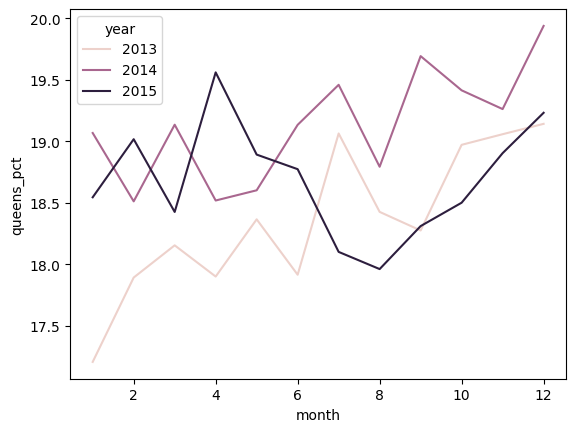

In [15]:
# Visualize Queens' share over time
queens_with_context['year'] = queens_with_context['year_month'].dt.year
queens_with_context['month'] = queens_with_context['year_month'].dt.month

sns.lineplot(data=queens_with_context, x='month', y='queens_pct', hue='year')

**Answer**: Queens accounted for approximately 17-20% of all misdemeanor arrests each month, with an average around 18-19%. The percentage was fairly stable across the 2013-2015 period.

---

## Exercise 3: Pattern 3 Practice - Borough Recovery Rates

**Question**: Did the Bronx and Manhattan recover at the same rate from 2014 to 2015?

**Pattern**: Compare Filtered DataFrames

**Approach**:
1. Filter to just Bronx and Manhattan
2. Count arrests by borough and year
3. Separate 2014 and 2015 data
4. Merge them with suffixes
5. Calculate percentage change

In [16]:
# Step 1: Filter to just Bronx (B) and Manhattan (M)
bronx_manhattan = df[df['ARREST_BORO'].isin(['B', 'M'])]

print(f"Arrests in Bronx and Manhattan: {len(bronx_manhattan):,}")
print(bronx_manhattan['ARREST_BORO'].value_counts())

Arrests in Bronx and Manhattan: 513,427
ARREST_BORO
M    274622
B    238805
Name: count, dtype: int64


In [17]:
# Step 2: Count arrests by borough and year
borough_year = bronx_manhattan.groupby(['ARREST_BORO', 'year']).size().reset_index(name='arrests')

print("Arrests by borough and year:")
print(borough_year)

Arrests by borough and year:
  ARREST_BORO  year  arrests
0           B  2013    83709
1           B  2014    82690
2           B  2015    72406
3           M  2013    97233
4           M  2014    93787
5           M  2015    83602


In [18]:
# Step 3: Separate 2014 and 2015 data
arrests_2014 = borough_year[borough_year['year'] == 2014]
arrests_2015 = borough_year[borough_year['year'] == 2015]

print("2014 arrests:")
print(arrests_2014)
print("\n2015 arrests:")
print(arrests_2015)

2014 arrests:
  ARREST_BORO  year  arrests
1           B  2014    82690
4           M  2014    93787

2015 arrests:
  ARREST_BORO  year  arrests
2           B  2015    72406
5           M  2015    83602


In [19]:
# Step 4: Merge on borough with suffixes
comparison = pd.merge(arrests_2014, arrests_2015, 
                     on='ARREST_BORO', 
                     how='inner',
                     suffixes=('_2014', '_2015'))

print("Merged comparison:")
print(comparison)

Merged comparison:
  ARREST_BORO  year_2014  arrests_2014  year_2015  arrests_2015
0           B       2014         82690       2015         72406
1           M       2014         93787       2015         83602


In [20]:
# Step 5: Calculate percentage change
comparison['pct_change'] = ((comparison['arrests_2015'] - comparison['arrests_2014']) / 
                            comparison['arrests_2014']) * 100

print("Recovery rates by borough:")
print(comparison[['ARREST_BORO', 'arrests_2014', 'arrests_2015', 'pct_change']])

# Print the answer
for _, row in comparison.iterrows():
    if row['ARREST_BORO'] == 'B':
        borough_name = "Bronx"
    else:
        borough_name = "Manhattan"
    print(f"\n{borough_name}: {row['pct_change']:+.1f}% change from 2014 to 2015")

Recovery rates by borough:
  ARREST_BORO  arrests_2014  arrests_2015  pct_change
0           B         82690         72406  -12.436812
1           M         93787         83602  -10.859714

Bronx: -12.4% change from 2014 to 2015

Manhattan: -10.9% change from 2014 to 2015


<Axes: xlabel='ARREST_BORO', ylabel='pct_change'>

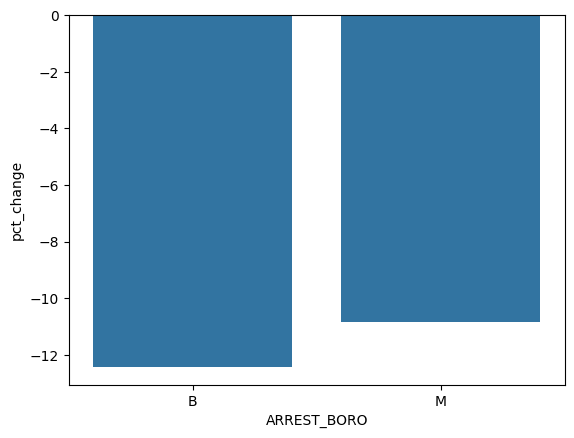

In [21]:
# Visualize the comparison
sns.barplot(data=comparison, x='ARREST_BORO', y='pct_change')

**Answer**: Both boroughs saw continued decreases from 2014 to 2015. The Bronx had a larger drop (-12.4%) compared to Manhattan (-10.9%). This means Manhattan's arrests declined less severely, though neither borough fully recovered to 2014 levels during this period.